# Uso definitivo del modelo

$$
\begin{align}
\frac{dS}{dt}=\xi_{1}M(t)+\xi_{2}E(t)-\xi_{3}S(t) \\
\frac{dE}{dt}=\xi_{4}M(t)+\xi_{5}S(t)-\xi_{6}E(t)
\end{align}
$$

In [1]:
# cargar bases de datos de ambos paises
import pandas as pd

df = pd.read_csv('../../data/processed/salud/unified.csv')
print(df.head())


   Unnamed: 0   Año       USD mex        USD ch   dG/dt (mex)    dG/dt (ch)
0           0  2004  3.437250e+10  6.493000e+09  0.000000e+00  0.000000e+00
1           1  2005  3.443720e+10  6.944000e+09  6.470000e+07  4.510000e+08
2           2  2006  3.845950e+10  8.485000e+09  4.022300e+09  1.541000e+09
3           3  2007  4.166450e+10  9.633000e+09  3.205000e+09  1.148000e+09
4           4  2008  4.561570e+10  1.063700e+10  3.951200e+09  1.004000e+09


In [2]:
# leer las bases de datos para los egresos 
df_mex=pd.read_csv('../../data/processed/salud/egresos_méxico.csv')
df_ch=pd.read_csv('../../data/processed/salud/egresos_chile.csv')

df['E mex']=df_mex['Egresos']
df['E ch']=df_ch['Egresos']
df = df.drop('Unnamed: 0',axis=1)

print(df.head())

    Año       USD mex        USD ch   dG/dt (mex)    dG/dt (ch)    E mex  \
0  2004  3.437250e+10  6.493000e+09  0.000000e+00  0.000000e+00  4416313   
1  2005  3.443720e+10  6.944000e+09  6.470000e+07  4.510000e+08  4539477   
2  2006  3.845950e+10  8.485000e+09  4.022300e+09  1.541000e+09  4658305   
3  2007  4.166450e+10  9.633000e+09  3.205000e+09  1.148000e+09  4922227   
4  2008  4.561570e+10  1.063700e+10  3.951200e+09  1.004000e+09  5123675   

     E ch  
0  248235  
1  248169  
2  278142  
3  299953  
4  315315  


In [3]:
# cambios

df['dE/dt mex']=df['E mex'].diff().fillna(0)
df['dE/dt ch']=df['E ch'].diff().fillna(0)

df = df.iloc[:17]
print(df.head())
df.to_csv('../../data/processed/salud/unified_mod.csv')

    Año       USD mex        USD ch   dG/dt (mex)    dG/dt (ch)    E mex  \
0  2004  3.437250e+10  6.493000e+09  0.000000e+00  0.000000e+00  4416313   
1  2005  3.443720e+10  6.944000e+09  6.470000e+07  4.510000e+08  4539477   
2  2006  3.845950e+10  8.485000e+09  4.022300e+09  1.541000e+09  4658305   
3  2007  4.166450e+10  9.633000e+09  3.205000e+09  1.148000e+09  4922227   
4  2008  4.561570e+10  1.063700e+10  3.951200e+09  1.004000e+09  5123675   

     E ch  dE/dt mex  dE/dt ch  
0  248235        0.0       0.0  
1  248169   123164.0     -66.0  
2  278142   118828.0   29973.0  
3  299953   263922.0   21811.0  
4  315315   201448.0   15362.0  


# Analisis de Mexico

In [4]:
# modelo mexico
import statsmodels.api as sm

# cargar datos de poblacion mayores
pobmex=pd.read_csv('../../data/processed/poblaciones/mexico.csv').iloc[2:19].reset_index()['Poblacion adultos mayores (65+)']

# salud

X_s=pd.DataFrame({
    'poblacion':pobmex.values,
    'egresos':df['E mex'].values,
    'salud': df['USD mex'].values,
    
})
Y_s=df['dG/dt (mex)']
X_s=sm.add_constant(X_s,prepend=False)

modelo_s=sm.OLS(Y_s,X_s).fit()
print(modelo_s.summary())

# egresos

X_e=pd.DataFrame({
    'poblacion' : pobmex.values,
    'salud': df['USD mex'].values,
    'egresos' : df['E mex'].values,
})
Y_e=df['dE/dt mex']
X_e=sm.add_constant(X_e,prepend=False)

modelo_e=sm.OLS(Y_e,X_e).fit()
print(modelo_e.summary())



                            OLS Regression Results                            
Dep. Variable:            dG/dt (mex)   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     10.13
Date:                Fri, 28 Nov 2025   Prob (F-statistic):            0.00104
Time:                        10:34:59   Log-Likelihood:                -384.50
No. Observations:                  17   AIC:                             777.0
Df Residuals:                      13   BIC:                             780.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
poblacion  -4879.1222   1270.124     -3.841      0.0

In [5]:
# Graficacion


def sistema_edos(t, y):
    # y = [J, A, M, S, E]
    jt, at, mt, st, et = y

    # COEFICIENTES modelo poblacion
    c1 = -0.0085  # tasa de natalidad
    c2 = -0.0207  # tasa de mortalidad jóvenes
    #const1= -2.161e+06
    tj=0.0359
    c3 = -0.0036  # tasa de mortalidad adultos (positiva)
    #const2=-3.146e+07
    ta=-0.0002
    c4 =  -0.0344 # tasa de mortalidad mayores
    #const3=-1.404e+06

    xi1 = 200       # antes 4879.1222
    xi2 = 150       # antes 3776.4564
    xi3 = -0.02     # antes -0.6075

    xi4 = 0.005     # antes -0.2174
    xi5 = 5.0e-06   # antes 5.133e-05
    xi6 = 0.01      # antes -0.6949

    const4 = 1.0e9  # antes 2.635e10
    const5 = -2.0e5 # antes -2.494e06
    

    # ECUACIONES Poblacion
    dyJ = c1*at-c2*jt#+const1
    dyA = tj*jt-c3*at#+const2
    dyM = ta*at-c4*mt#+const3

    # Ecuaciones salud

    dyS = xi1*mt + xi2*et + xi3*st + const4
    dyE = xi4*mt + xi5*st + xi6*et + const5

    return [dyJ, dyA, dyM, dyS, dyE]



In [6]:
import numpy as np
def RK4(func, y0, t0, tf, h):
    t_values = np.arange(t0, tf + h, h)
    n = len(t_values)
    y_values = np.zeros((n, len(y0)), dtype=float)
    y_values[0] = y0

    for i in range(1, n):
        k1 = np.array(func(t_values[i-1], y_values[i-1]))
        k2 = np.array(func(t_values[i-1] + h/2, y_values[i-1] + h*k1/2))
        k3 = np.array(func(t_values[i-1] + h/2, y_values[i-1] + h*k2/2))
        k4 = np.array(func(t_values[i-1] + h,   y_values[i-1] + h*k3))
        y_values[i] = y_values[i-1] + h*(k1 + 2*k2 + 2*k3 + k4)/6

    return t_values, y_values

# y0 = [J, A, E, S, E] en 2005
y0 = [27858970,65630336,5953231, 34372500000.0, 4416313]
t0, tf, h = 0, 25, 0.01

t, y = RK4(sistema_edos, y0, t0, tf, h)

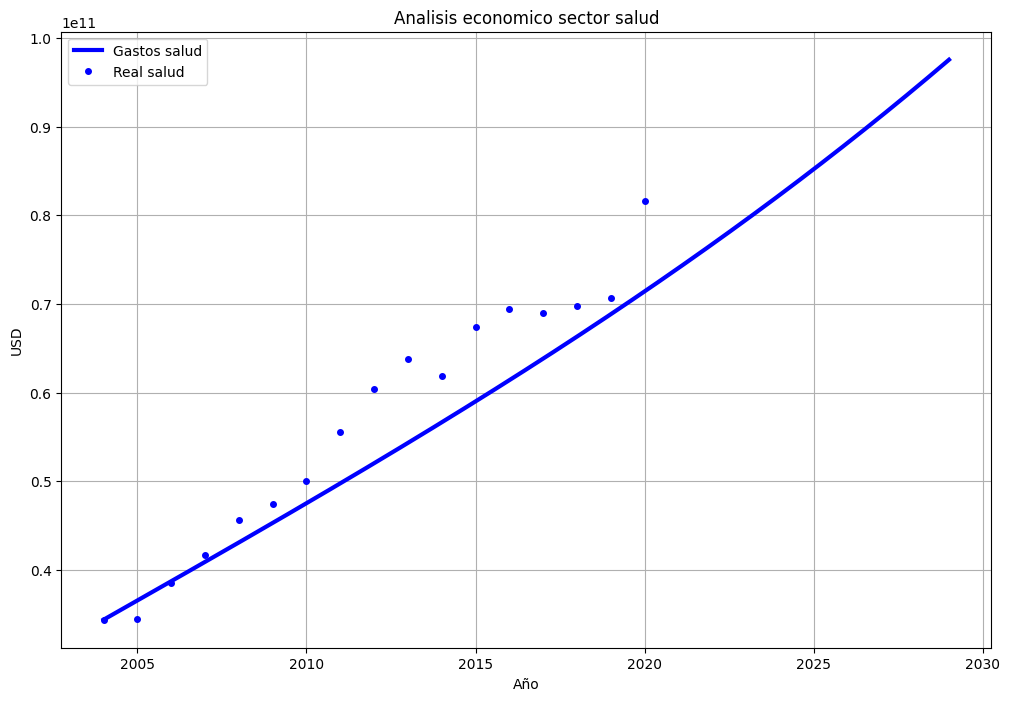

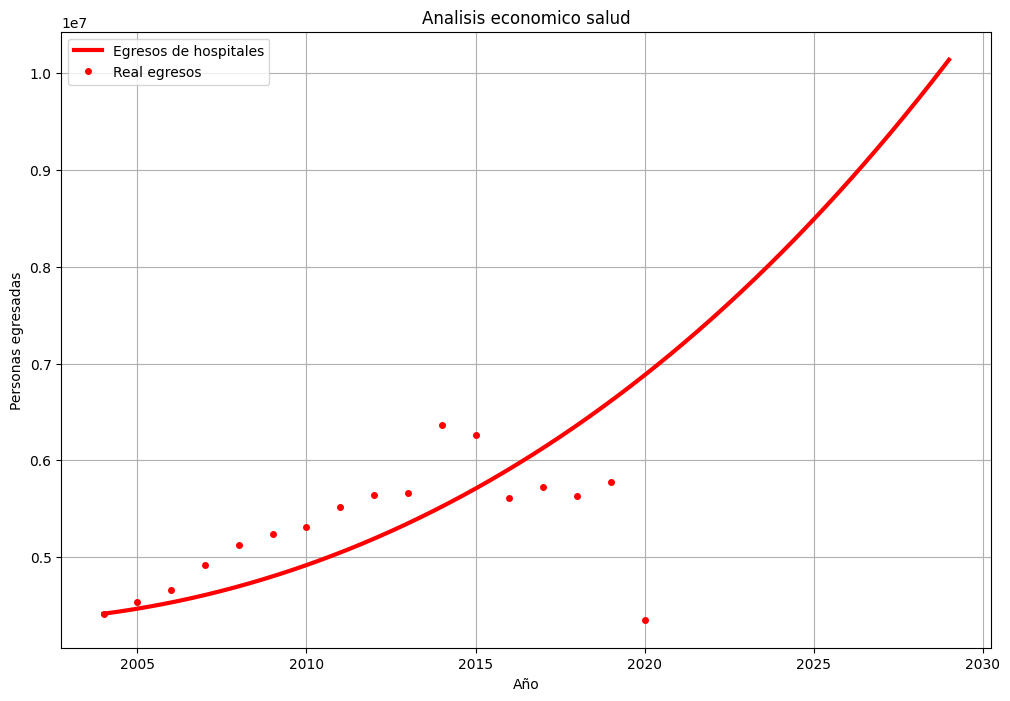

In [7]:
import matplotlib.pyplot as plt
years=t+2004
fig, ax= plt.subplots(1,1,figsize=(12,8))

years_real=df['Año']

# salud
ax.plot(years, y[:,3],'-b',linewidth=3,label='Gastos salud')
ax.plot(years_real, df['USD mex'], 'bo',markersize=4,label='Real salud')

ax.set_title('Analisis economico sector salud')
ax.set_xlabel('Año')
ax.set_ylabel('USD')
ax.grid(True)
ax.legend()
plt.show()

fig, bx = plt.subplots(1,1,figsize=(12,8))

bx.plot(years,y[:,4],'-r',linewidth=3,label='Egresos de hospitales')
bx.plot(years_real,df['E mex'],'ro',markersize=4,label='Real egresos')

bx.set_title('Analisis economico salud')
bx.set_xlabel("Año")
bx.set_ylabel("Personas egresadas")
bx.grid(True)
bx.legend()
plt.show()


# Analisis de Chile

In [8]:
# leer poblaciones chile

pobch=pd.read_csv('../../data/processed/poblaciones/chile.csv').iloc[2:19].reset_index()['Poblacion total mayores (65+ años)']

# salud

X_s=pd.DataFrame({
    'poblacion': pobch.values,
    'egresos': df['E ch'].values,
    'gasto salud': df['USD ch'].values
})

Y_s= df['dG/dt (ch)']

#X_s=sm.add_constant(X_s,prepend=False)
modelo_s=sm.OLS(Y_s,X_s).fit()

display(modelo_s.summary())


# egresos

X_e=pd.DataFrame({
    'poblacion' : pobch.values,
    'gasto salud' : df['USD ch'],
    'egresos' : df['E ch']
})

Y_e=df['dE/dt ch']
X_e=sm.add_constant(X_e,prepend=False)

modelo_e=sm.OLS(Y_e,X_e).fit()

display(modelo_e.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             dG/dt (ch)   R-squared (uncentered):                   0.867
Model:                            OLS   Adj. R-squared (uncentered):              0.838
Method:                 Least Squares   F-statistic:                              30.40
Date:                Fri, 28 Nov 2025   Prob (F-statistic):                    2.18e-06
Time:                        10:34:59   Log-Likelihood:                         -369.14
No. Observations:                  17   AIC:                                      744.3
Df Residuals:                      14   BIC:                                      746.8
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
poblacion    1007.9020   1049.424      0.960      0.353   -1242.890    3258.694
egresos     -5908.0191   4567.206     -1.294      0.217   -1.57e+04    3887.664
gasto salud     0.1090      0.041      2.651      0.019       0.021       0.197
==============================================================================
Omnibus:                        1.441   Durbin-Watson:                   2.389
Prob(Omnibus):                  0.487   Jarque-Bera (JB):                0.344
Skew:                          -0.302   Prob(JB):                        0.842
Kurtosis:                       3.347   Cond. No.                     4.85e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 4.85e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               dE/dt ch   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     9.311
Date:                Fri, 28 Nov 2025   Prob (F-statistic):            0.00150
Time:                        10:34:59   Log-Likelihood:                -189.20
No. Observations:                  17   AIC:                             386.4
Df Residuals:                      13   BIC:                             389.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
poblacion      -0.2915      0.238     -1.225      0.242      -0.806       0.223
gasto salud  5.796e-06   9.51e-06      0.609      0.553   -1.48e-05    2.63e-05
egresos         0.6058      0.145      4.170      0.001       0.292       0.920
const        2.079e+05    2.3e+05      0.903      0.383   -2.89e+05    7.05e+05
==============================================================================
Omnibus:                        0.137   Durbin-Watson:                   1.830
Prob(Omnibus):                  0.934   Jarque-Bera (JB):                0.313
Skew:                          -0.160   Prob(JB):                        0.855
Kurtosis:                       2.417   Cond. No.                     9.11e+11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.11e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

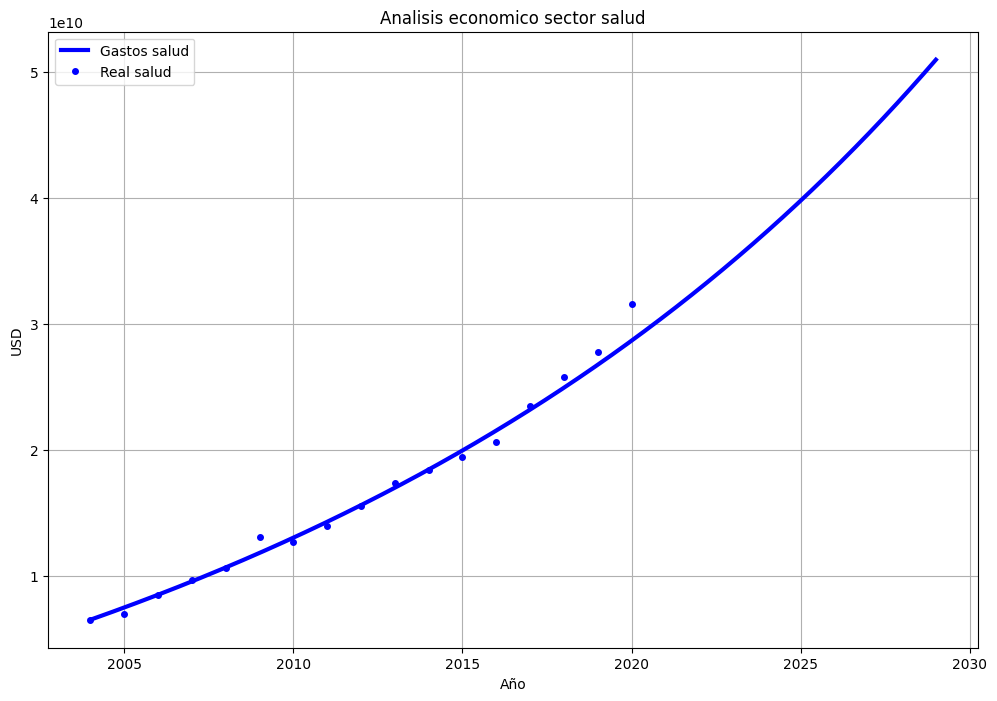

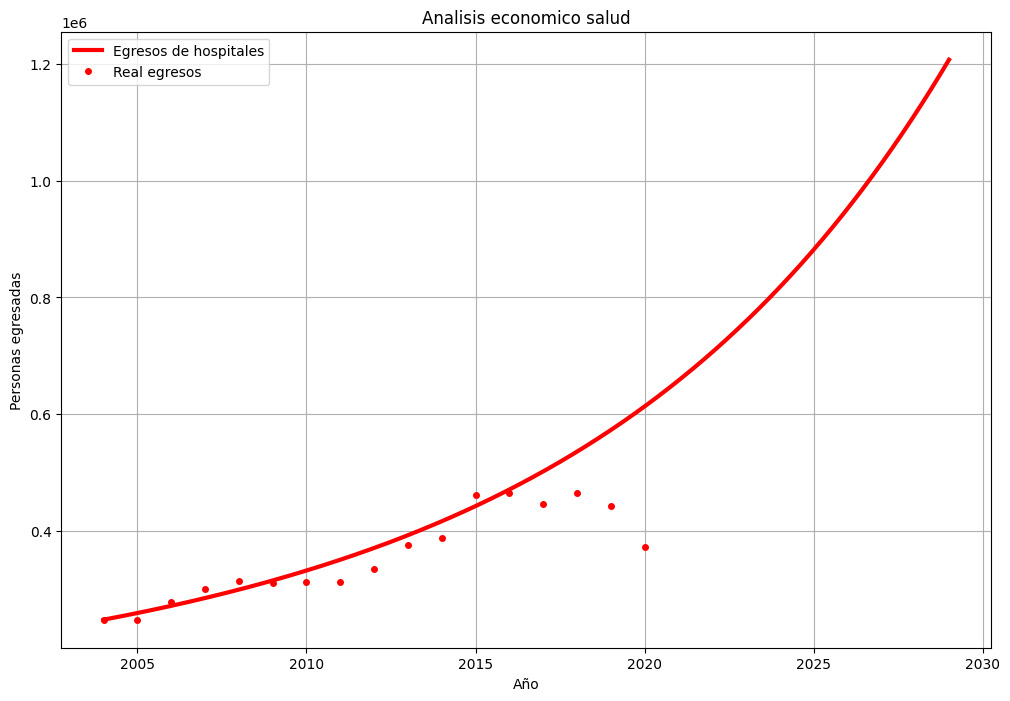

In [9]:
def sistema_edos(t, y):
    # y = [J, A, M, S, E]
    jt, at, mt, st, et = y

    # COEFICIENTES modelo poblacion
    c1 = -0.0085  # tasa de natalidad
    c2 = -0.0207  # tasa de mortalidad jóvenes
    #const1= -2.161e+06
    tj=0.0359
    c3 = -0.0036  # tasa de mortalidad adultos (positiva)
    #const2=-3.146e+07
    ta=-0.0002
    c4 =  -0.0344 # tasa de mortalidad mayores
    #const3=-1.404e+06

     # Coeficientes salud para S (nuevo ajuste)

    xi1 = 500       # efecto de M
    xi2 = 900        # efecto de E
    xi3 = 0.010

    # Coeficientes salud para E

    xi4 = -0.007       # antes 0.35
    xi5 = 6.0e-08     # antes 8.0e-06
    xi6 = 0.10       # antes -0.25
    const5 = -5.0e3   # antes -1.0e5   # corrige el nivel de la derivada

     

    # ECUACIONES Poblacion
    dyJ = c1*at-c2*jt#+const1
    dyA = tj*jt-c3*at#+const2
    dyM = ta*at-c4*mt#+const3

    # Ecuaciones salud

    dyS = xi1*mt + xi2*et + xi3*st #+ const4
    dyE = xi4*mt + xi5*st + xi6*et + const5

    return [dyJ, dyA, dyM, dyS, dyE]


y0 = [4057629.0,10640163.0,1324341.0, 6493000000.0,248235]
t0, tf, h = 0, 25, 0.01

t, y = RK4(sistema_edos, y0, t0, tf, h)

years=t+2004
fig, ax= plt.subplots(1,1,figsize=(12,8))

years_real=df['Año']

# salud
ax.plot(years, y[:,3],'-b',linewidth=3,label='Gastos salud')
ax.plot(years_real, df['USD ch'], 'bo',markersize=4,label='Real salud')

ax.set_title('Analisis economico sector salud')
ax.set_xlabel('Año')
ax.set_ylabel('USD')
ax.grid(True)
ax.legend()
plt.show()

fig, bx = plt.subplots(1,1,figsize=(12,8))

bx.plot(years,y[:,4],'-r',linewidth=3,label='Egresos de hospitales')
bx.plot(years_real,df['E ch'],'ro',markersize=4,label='Real egresos')

bx.set_title('Analisis economico salud')
bx.set_xlabel("Año")
bx.set_ylabel("Personas egresadas")
bx.grid(True)
bx.legend()
plt.show()